# Test on 1 csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import os

df = pd.read_csv("MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

print("Shape:", df.shape)
print("Columns:", df.columns[:10])  # preview first columns
print("Label distribution:\n", df[" Label"].value_counts())

Shape: (225745, 79)
Columns: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std'],
      dtype='object')
Label distribution:
  Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64


In [ ]:
df.columns = df.columns.str.strip()   # remove spaces from col names

X = df.drop("Label", axis=1, errors="ignore")
y = df["Label"].values

# Convert all to numeric, replace inf/NaN
X = X.apply(pd.to_numeric, errors="coerce")
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Processed features shape:", X_scaled.shape)
print("Classes:", np.unique(y))

Processed features shape: (225745, 78)
Classes: ['BENIGN' 'DDoS']


In [3]:
def enn_test(X, y, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    misclassified = (y_pred != y)
    mis_rate = np.mean(misclassified)
    return y_pred, misclassified, mis_rate

print("\n ENN Misclassification Rates ")
for k in [3, 5, 7]:
    y_pred, mis_mask, mis_rate = enn_test(X_scaled, y, k)
    print(f"k={k} → Overall misclassification rate: {mis_rate:.6f}")

    # Per-class misclassification
    results = {}
    for cls in np.unique(y):
        idx = (y == cls)
        if np.sum(idx) > 0:
            cls_rate = np.mean(y_pred[idx] != y[idx])
            results[cls] = cls_rate
    print(f"  Per-class misclassification: {results}")


 ENN Misclassification Rates 
k=3 → Overall misclassification rate: 0.000151
  Per-class misclassification: {'BENIGN': np.float64(0.00021490411183200638), 'DDoS': np.float64(0.00010154108117818898)}
k=5 → Overall misclassification rate: 0.000173
  Per-class misclassification: {'BENIGN': np.float64(0.0002456046992365787), 'DDoS': np.float64(0.00011716278597483344)}
k=7 → Overall misclassification rate: 0.000190
  Per-class misclassification: {'BENIGN': np.float64(0.00027630528664115105), 'DDoS': np.float64(0.00012497363837315567)}


In [4]:
BG_PORTS = {0, 53, 67, 68, 111, 123, 137, 161, 179, 389, 427, 520, 1723, 1900}

def port_test(df, label_col="Label", port_col="Destination Port"):
    results = {}
    for cls, group in df.groupby(label_col):
        total = len(group)
        unclear = group[group[port_col].isin(BG_PORTS)]
        results[cls] = len(unclear) / total if total > 0 else 0
    return results

ugt_results = port_test(df)

print("\n=== Port Test Results (UGT_C per class) ===")
for cls, val in ugt_results.items():
    print(f"{cls}: {val:.3f}")


=== Port Test Results (UGT_C per class) ===
BENIGN: 0.337
DDoS: 0.000


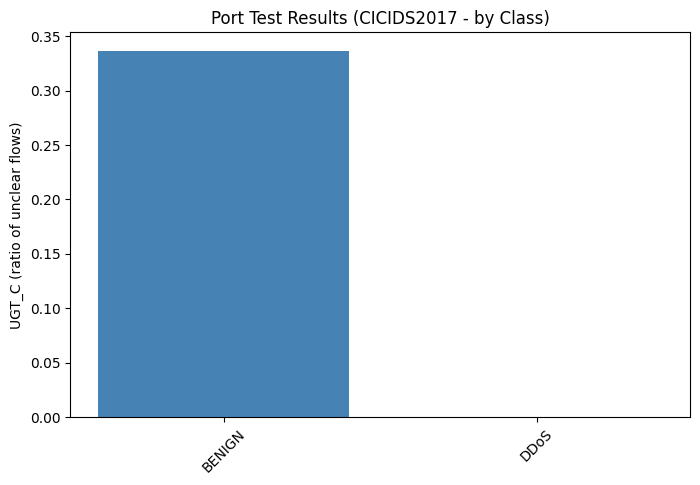

In [5]:
plt.figure(figsize=(8,5))
plt.bar(ugt_results.keys(), ugt_results.values(), color="steelblue")
plt.xticks(rotation=45)
plt.ylabel("UGT_C (ratio of unclear flows)")
plt.title("Port Test Results (CICIDS2017 - by Class)")
plt.show()

# Full dataset test

In [3]:
# Helper Functions
def preprocess_data(df):
    df.columns = df.columns.str.strip()  
    X = df.drop("Label", axis=1, errors="ignore")
    y = df["Label"].values

    # convert to numeric
    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)

    # normalize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

def enn_test(X, y, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    mis_rate = np.mean(y_pred != y)

    per_class = {}
    for cls in np.unique(y):
        idx = (y == cls)
        if np.sum(idx) > 0:
            per_class[cls] = np.mean(y_pred[idx] != y[idx])
    return mis_rate, per_class

BG_PORTS = {0, 53, 67, 68, 111, 123, 137, 161, 179, 389, 427, 520, 1723, 1900}

def port_test(df, label_col="Label", port_col="Destination Port"):
    results = {}
    for cls, group in df.groupby(label_col):
        total = len(group)
        unclear = group[group[port_col].isin(BG_PORTS)]
        results[cls] = len(unclear) / total if total > 0 else 0
    return results

# Main Loop over all CSVs

folder = "MachineLearningCVE"
results = []

for file in os.listdir(folder):
    if file.endswith(".csv"):
        filepath = os.path.join(folder, file)
        print(f"\n=== Processing {file} ===")
        try:
            df = pd.read_csv(filepath)
            print("Shape:", df.shape)

            # Preprocess
            X_scaled, y = preprocess_data(df)

            # ENN
            mis_rate, per_class = enn_test(X_scaled, y, k=5)

            # Port Test
            port_results = port_test(df)

            # Store results
            for cls in np.unique(y):
                results.append({
                    "File": file,
                    "Class": cls,
                    "ENN_misrate": per_class.get(cls, np.nan),
                    "PortTest_UGT_C": port_results.get(cls, np.nan)
                })

        except Exception as e:
            print(f"Error with {file}: {e}")



=== Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ===
Shape: (225745, 79)

=== Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ===
Shape: (286467, 79)

=== Processing Friday-WorkingHours-Morning.pcap_ISCX.csv ===
Shape: (191033, 79)

=== Processing Monday-WorkingHours.pcap_ISCX.csv ===
Shape: (529918, 79)

=== Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ===
Shape: (288602, 79)

=== Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ===
Shape: (170366, 79)

=== Processing Tuesday-WorkingHours.pcap_ISCX.csv ===
Shape: (445909, 79)

=== Processing Wednesday-workingHours.pcap_ISCX.csv ===
Shape: (692703, 79)


# Summary Table

In [4]:
summary_df = pd.DataFrame(results)
print("\n=== Summary Results ===")
print(summary_df.head(20))

# Save to CSV
summary_df.to_csv("CICIDS2017_ENN_PortTest_Summary.csv", index=False, encoding="utf-8")


=== Summary Results ===
                                                 File  \
0    Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv   
1    Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv   
2   Friday-WorkingHours-Afternoon-PortScan.pcap_IS...   
3   Friday-WorkingHours-Afternoon-PortScan.pcap_IS...   
4           Friday-WorkingHours-Morning.pcap_ISCX.csv   
5           Friday-WorkingHours-Morning.pcap_ISCX.csv   
6                   Monday-WorkingHours.pcap_ISCX.csv   
7   Thursday-WorkingHours-Afternoon-Infilteration....   
8   Thursday-WorkingHours-Afternoon-Infilteration....   
9   Thursday-WorkingHours-Morning-WebAttacks.pcap_...   
10  Thursday-WorkingHours-Morning-WebAttacks.pcap_...   
11  Thursday-WorkingHours-Morning-WebAttacks.pcap_...   
12  Thursday-WorkingHours-Morning-WebAttacks.pcap_...   
13                 Tuesday-WorkingHours.pcap_ISCX.csv   
14                 Tuesday-WorkingHours.pcap_ISCX.csv   
15                 Tuesday-WorkingHours.pcap_ISCX.csv   
16    

# Plot comparison

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# barplot per file
for file in summary_df["File"].unique():
    subset = summary_df[summary_df["File"] == file]

    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()

    # ENN misrate (left axis, orange)
    subset.plot(
        x="Class", y="ENN_misrate", kind="bar",
        color="orange", ax=ax1, position=0, width=0.4, legend=False
    )

    # Port Test UGT_C (right axis, steelblue)
    subset.plot(
        x="Class", y="PortTest_UGT_C", kind="bar",
        color="steelblue", ax=ax2, position=1, width=0.4, legend=False
    )

    ax1.set_ylabel("ENN misclassification rate", color="orange")
    ax2.set_ylabel("PortTest UGT_C", color="steelblue")
    ax1.set_title(f"Comparison of ENN vs Port Test – {file}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"plots/{file}_comparison.png")
    plt.close()

print("Saved plots in folder: plots/")

Saved plots in folder: plots/


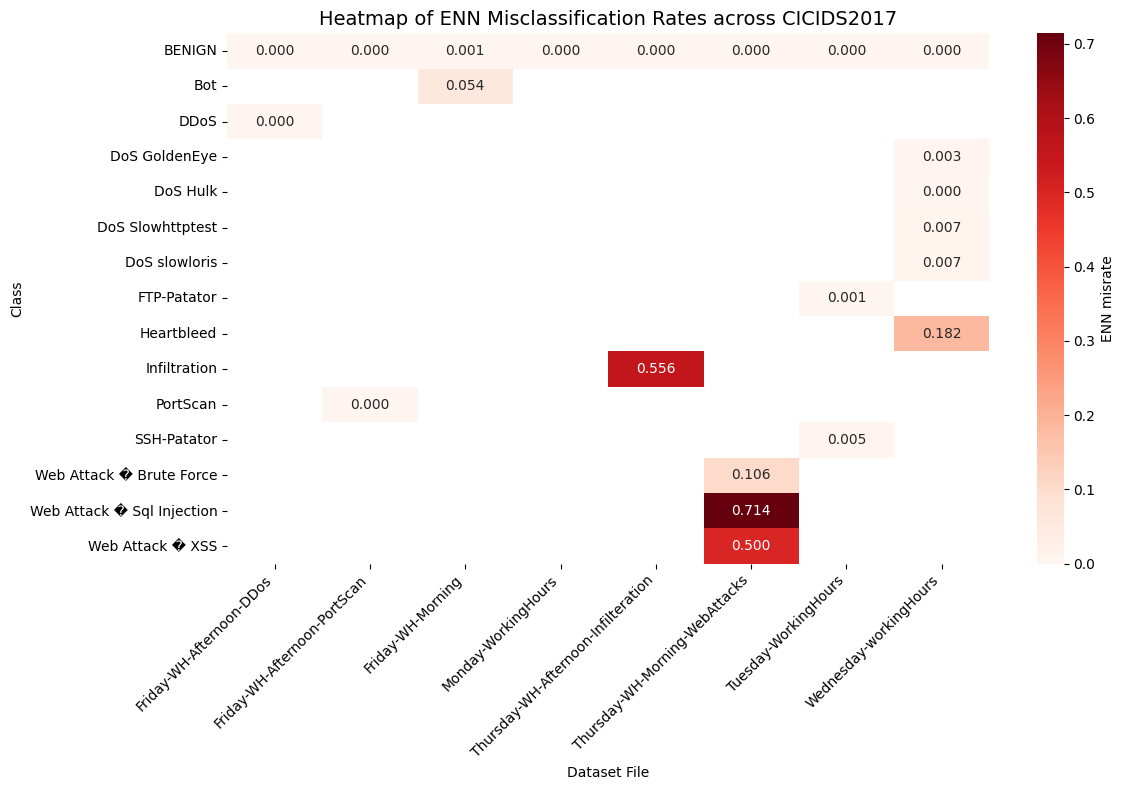

<Figure size 640x480 with 0 Axes>

In [ ]:
pivot_df = summary_df.pivot(index="Class", columns="File", values="ENN_misrate")

# Optional: filter out BENIGN if we want to highlight only attacks
# pivot_df = pivot_df[pivot_df.index != "BENIGN"]

# Shorten file names
pivot_df.columns = [col.replace(".pcap_ISCX.csv", "").replace("WorkingHours-", "WH-") for col in pivot_df.columns]

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df,
    annot=True, fmt=".3f",
    cmap="Reds",
    cbar_kws={'label': 'ENN misrate'}
)
plt.title("Heatmap of ENN Misclassification Rates across CICIDS2017", fontsize=14)
plt.xlabel("Dataset File")
plt.ylabel("Class")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("CICIDS2017_ENN_heatmap.png", dpi=300)

plt.show()